# Обучение Word2Vec

Данный ноутбук представляет собой переделанный train_fasttext данный организаторами, здесь я пробовал провести очистку и нормазилацию текста. Бейзлайн я сохранил, чтобы визуально сравнивать качество эмбедингов бейзлайна и моих

In [1]:
from gensim.models.fasttext import FastText
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Выгрузим все чеки из размеченного, неразмеченного и тестового датасета

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/alpha/train_supervised_dataset.csv").fillna("")
uns_train_df = pd.read_csv("/content/drive/MyDrive/alpha/train_unsupervised_dataset.csv").fillna("")
test_df = pd.read_csv("/content/drive/MyDrive/alpha/test_dataset.csv")
names = pd.concat((train_df[["name"]], test_df)).reset_index(drop=True)
names

В качестве предобработки приведем все к нижнему регистру
Токенизируем по пробельным символам

In [4]:
names["tokens"] = names["name"].str.lower().str.split()

In [5]:
FastText(names["tokens"], vector_size=300).save("fasttext.model")

Обученные векторы положим в файл `fasttext.model` для использования в моделях

In [6]:
fasttext = FastText.load('fasttext.model')

Для сравнения качества эмбедингов просто возьмем несколько случайных слов и,испльзуя t-SNE, отобразим их 2-х мерной плоскости

In [7]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [8]:
keys = ['пиво', "семечки", "йогурт", "печенье", "картон", "джем"] #слова, которые будем проверять

tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)

<ipython-input-9-f3dbd033767b>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


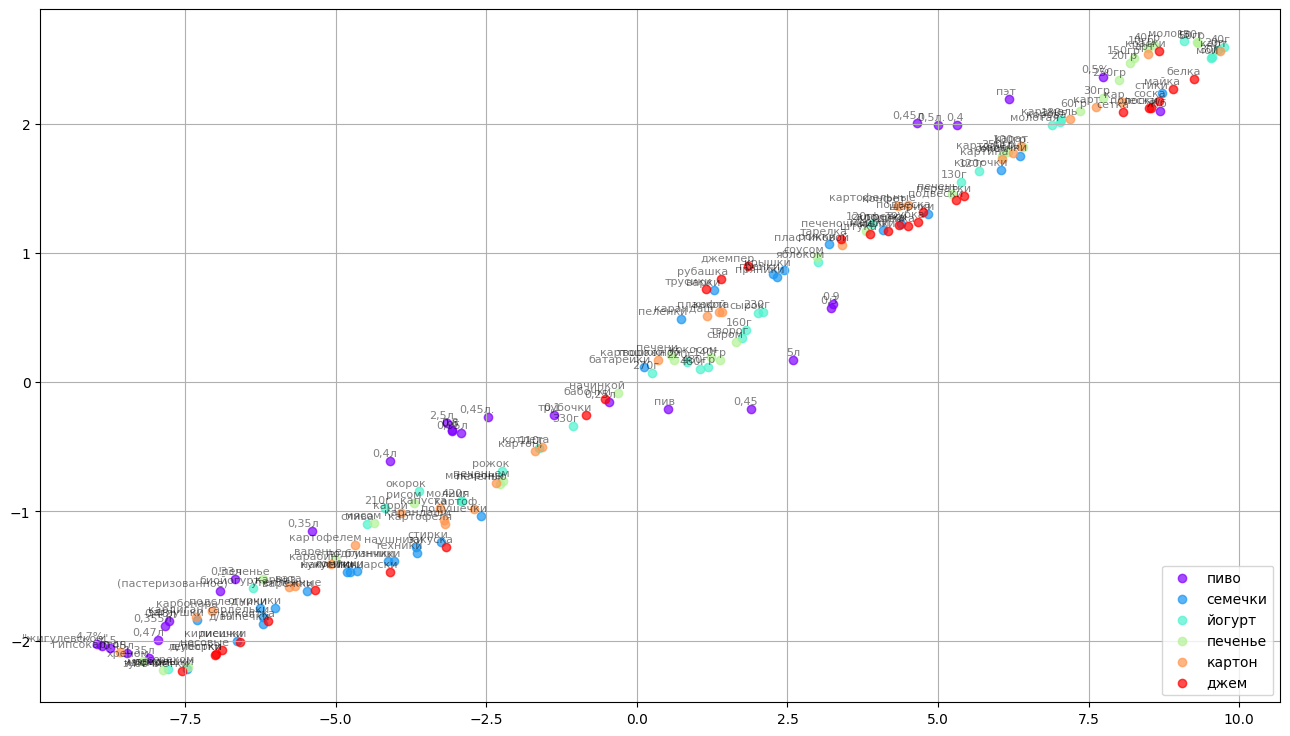

In [9]:
def tsne_plot_similar_words(labels, tsne_model, word2vec_model, a=0.7):
    embedding_clusters = []
    word_clusters = []
    for word in labels:
        embeddings = []
        words = []
        for similar_word, _ in word2vec_model.wv.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(word2vec_model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    embedding_clusters = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()


tsne_plot_similar_words(keys, tsne_model_en_2d, fasttext)

Как можно заметить, слова не разделяются по кластерам и картина очень в целом очень плохая. Видно также, что fasttext выделил много мусорных слов

In [10]:
import gc
gc.collect()

7377

Попробуем почистить текст от лишних символов и стоп слов. В качество word2vec модели будем применять обычный Gensim word2vec

In [23]:
import re
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
from gensim.models import Word2Vec
from tqdm.auto import tqdm

In [24]:
def tokenize(s):
    #сохраним также кавычки, потому что они часто выделяют название продукта
    s = re.sub('[^A-Za-zА-Яа-я\'\"\`d ]', '', s) #удаляем всё, кроме букв, цифр и кавычек
    s = re.sub('\d+', ' 1 ', s) #заменям все числа на 1
    s = re.sub('[\"]',' \" ',s) #разделяем кавычки
    s = re.sub('[\']',' \' ',s) #разделяем одиночные кавычки
    return s.lower().split()

In [25]:
names = pd.concat((train_df[["name"]], test_df)).reset_index(drop=True)
names['tokens'] = names.name.apply(tokenize)

In [26]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

words_pack = stopwords.words("russian")
reg_sent = names.tokens.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
reg_sent = [[word for word in sent if word not in words_pack] for sent in reg_sent] # удаляем стоп слова и сохраняем предложения, побитые на токены
reg_sent

[['petmax', 'бантик', 'леопард', 'красн', 'розой', 'шт'],
 ['бусы', 'елки', 'шарики'],
 ['футболка', 'piazza', 'italia', 'wr'],
 ['yixone', 'заколка', 'волос', 'девочки'],
 ['одежда', 'вес'],
 ['русалочка', 'губка', 'трио', 'трехслой', 'шт', 'люкс'],
 ['обоиartпп', 'белые', 'флизе', 'островки'],
 ['квас', 'очаковский', 'пряная', 'зима', 'л'],
 ['нб', 'маскапcosyмив'],
 ['наконечник', 'вилочный', 'изолированный', 'нви', 'шт', 'ekf', 'proxima'],
 ['o`stin', 'mtz', 'l', 'джемпер', 'мужск', 'жемчужнобелыйрl'],
 ['колготки', 'дет'],
 ['чокопай', 'дарк', 'какао', 'шторион'],
 ['аэратор', 'нв', 'нр'],
 ['подушка', 'бамбук', 'пб', 'поликоттон', 'хлопок', 'х', 'см'],
 ['белла', 'прокладки', 'гигиенич', 'классик', 'нова', 'комфорт', 'шт'],
 ['лаванда', 'гр', 'м'],
 ['купаты', 'мясные', 'кг', 'лоток', 'ма'],
 ['чай', 'нести', 'л', 'черный', 'лимон'],
 ['кефир', 'коровка', 'кореновки'],
 ['портьерная',
  'штора',
  'arco',
  'doro',
  'бежевый',
  'имитация',
  'льна',
  'х',
  'гарантия',
  'онла

In [28]:
gs = Word2Vec(reg_sent, min_count=1,vector_size=300,workers=3, window =3, sg = 1)

In [30]:
gs.save("big_word2vec.model")

In [ ]:
model = Word2Vec.load("/content/drive/MyDrive/alpha/gensim.model")

<ipython-input-9-f3dbd033767b>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


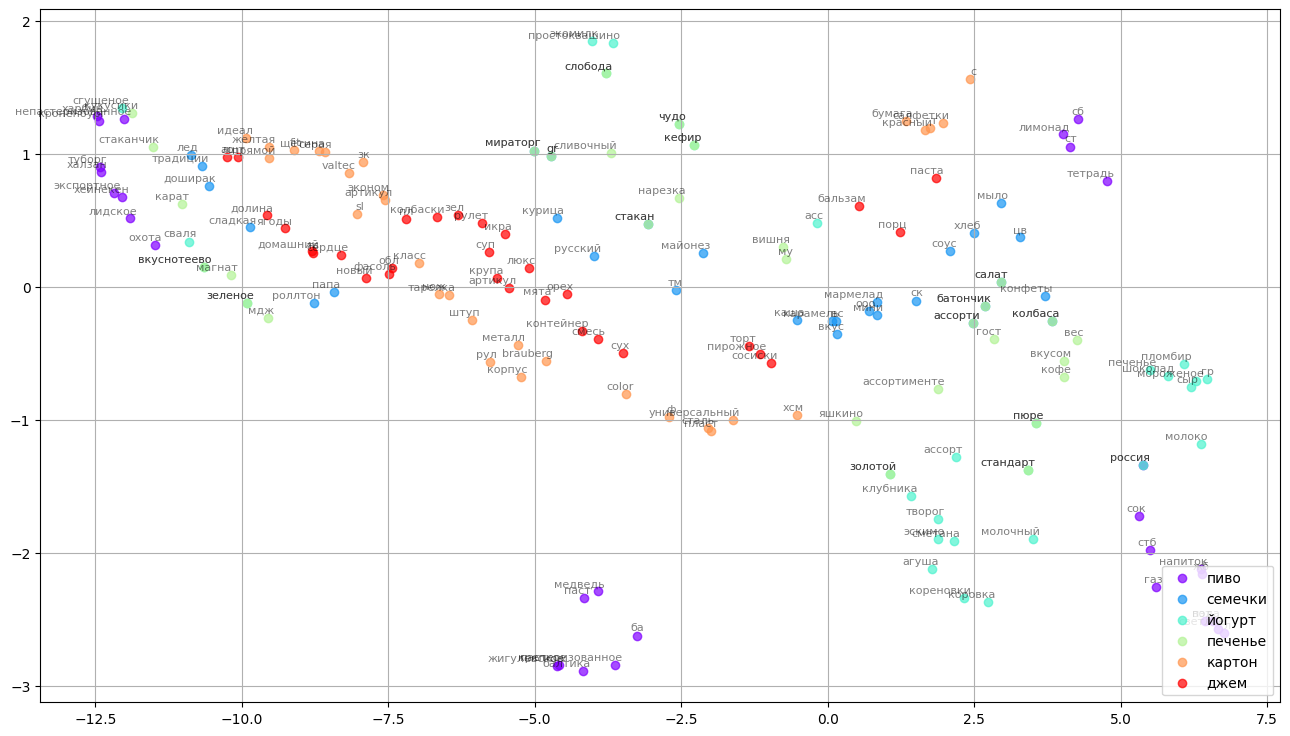

In [18]:
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
tsne_plot_similar_words(keys, tsne_model_en_2d, gs)

Видно, что после применния фильтрации слова стали более подходящими по контексту, а также начали лучше разбиваться на кластеры. Но этого качества всё ещё не достаточно

Тут очевидно нужно было использовать unsupervised train df, но я про него забыл)) Поэтому далее я пошел пробывать BERT и забил на baseline. Поскольку понял я это слишком поздно, замерить скор с использованием неразмеченной части на лидерборде не получилось.

<ipython-input-9-f3dbd033767b>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


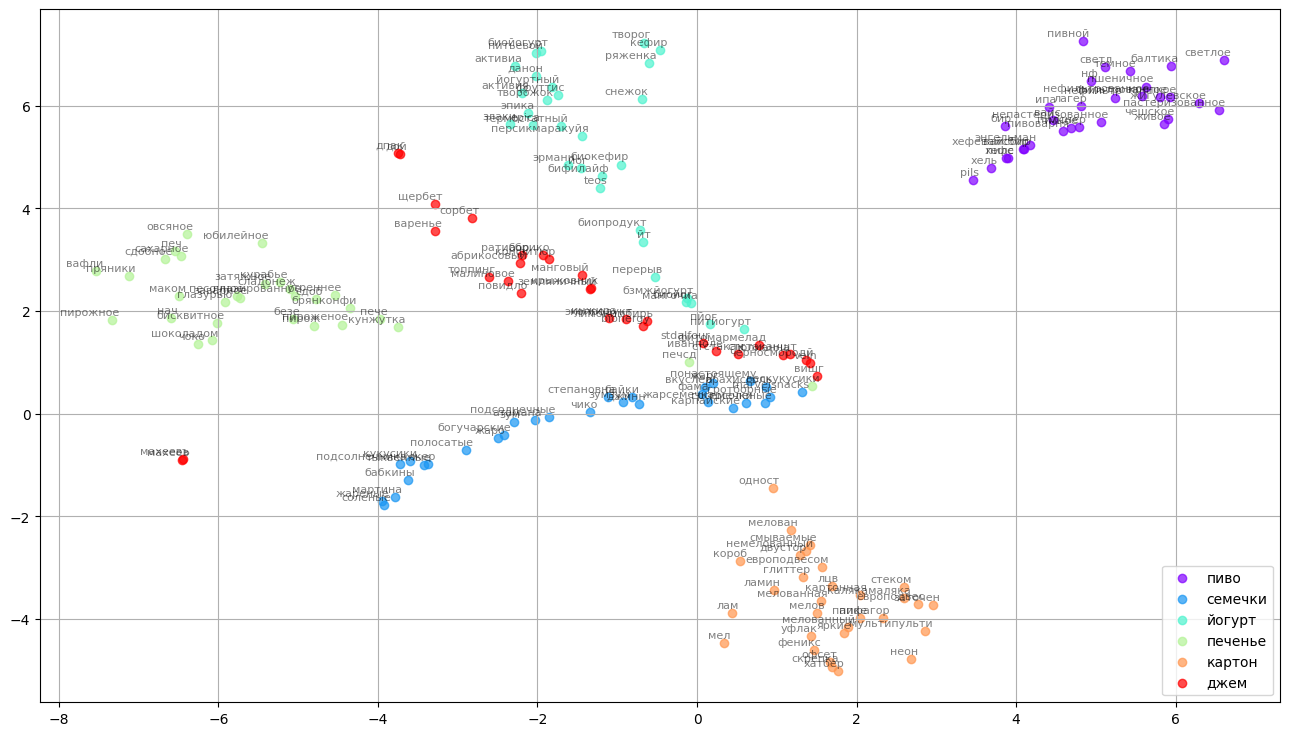

In [31]:
names = pd.concat((train_df[["name"]], test_df, uns_train_df)).reset_index(drop=True)
names['tokens'] = names.name.apply(tokenize)

words_pack = stopwords.words("russian")
reg_sent = names.tokens.to_list()

reg_sent = [[word for word in sent if word not in words_pack] for sent in reg_sent]

gs = Word2Vec(reg_sent, min_count=1,vector_size=300,workers=3, window =3, sg = 1)

tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
tsne_plot_similar_words(keys, tsne_model_en_2d, gs)

In [33]:
gs.save("big_word2vec.model")

так выглядят эмбединги, обученные с использованием uns train df